In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

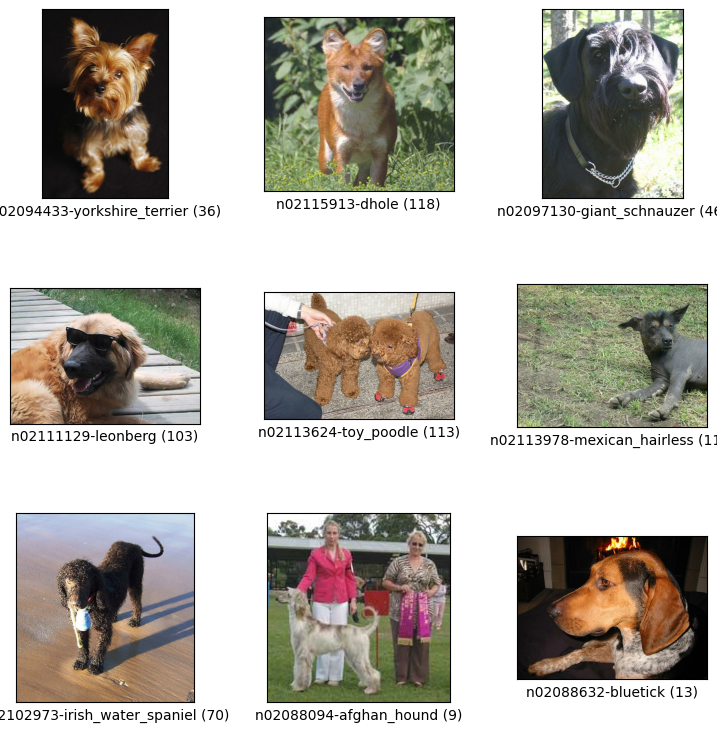

In [59]:
ds, ds_info = tfds.load('stanford_dogs', with_info=True, as_supervised=True)
train_dataset = ds['train']
test_dataset = ds['test']
fig = tfds.show_examples(train_dataset, ds_info)

In [60]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [61]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 768
Number of test batches: 192


In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [63]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [69]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [70]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [94]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (None, 160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [95]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

ValueError: Input 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, None, 160, 3), found shape=(500, 333, 3)